# Tugas Workshop PKAC

Muhammad Hafiz Ardiansyah

23/517963/PA/22226

## Import Library

Pada bagian ini, modul-modul yang akan digunakan pada proyek akan diimport terlebih dahulu.
1. OS -> modul yang digunakan untuk mengakses file lokal dari komputer
2. cv2 -> modul untuk melakukan image processing
3. numpy -> modul untuk membantu melakukan perhitungan matematis
4. matplotlib.pyplot -> modul untuk menampilkan visualisasi dari citra

In [2]:
import os
import cv2  # Image Procesing
import numpy as np # Perhitungan Matematis
import matplotlib.pyplot as plt # Visualisasi

## Load Dataset

Fungsi untuk membaca citra dari path

In [2]:
def load_image(image_path):
  image = cv2.imread(image_path)
  if image is None:
    print('Error: Could not load image.')
    return None, None
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return image, gray

In [3]:
sample_image, sample_image_gray = load_image('images/Muh_Hafiz_Ardiansyah/2.jpg')

In [4]:
sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

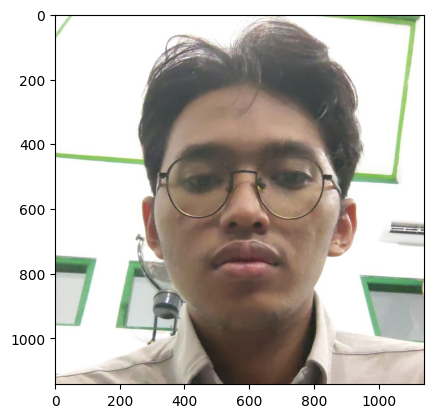

In [5]:
# Menampilkan citra pada sel output
plt.imshow(sample_image_rgb)

In [6]:
# Menampilkan citra dalam jendela baru
'''cv2.imshow("Muhammad Hafiz Ardiansyah", sample_image)

cv2.waitKey(0)
cv2.destroyAllWindows()'''

'cv2.imshow("Muhammad Hafiz Ardiansyah", sample_image)\n\ncv2.waitKey(0)\ncv2.destroyAllWindows()'

In [7]:
dataset_dir = 'images'
images = []
labels = []
for root, dirs, files, in os.walk(dataset_dir):
  if len(files) == 0:
    continue
  for f in files:
    _, image_gray = load_image(os.path.join(root, f))
    if image_gray is None:
      continue
    images.append(image_gray)
    labels.append(os.path.basename(root))  # Extract only the last part of the path

In [8]:
len(labels)

70

In [9]:
len(images)

70

In [10]:
print(labels[69])

W_Basudara


## Face Detection

In [11]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [12]:
def detect_faces(image_gray, scale_factor=1.1, min_neighbors=5, min_size=(30, 30)):
  faces = face_cascade.detectMultiScale(
    image_gray,
    scaleFactor=scale_factor,
    minNeighbors=min_neighbors,
    minSize=min_size
  )
  return faces

In [13]:
sample_faces = detect_faces(sample_image_gray, min_size=(30,30))

### Cropping Face

In [14]:
def crop_faces(image_gray, faces, return_all=False):
  cropped_faces = []
  selected_faces = []
  if len(faces) > 0:
    if return_all:
      for x, y, w, h in faces:
        selected_faces.append((x, y, w, h))
        cropped_faces.append(image_gray[y:y+h, x:x+w])
    else:
      x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])
      selected_faces.append((x, y, w, h))
      cropped_faces.append(image_gray[y:y+h, x:x+w])
  return cropped_faces, selected_faces

In [15]:
cropped_faces, _ = crop_faces(sample_image_gray, sample_faces)

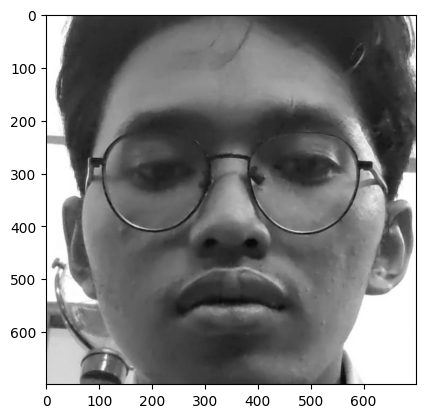

In [16]:
plt.imshow(cropped_faces[0], cmap='gray')

## Face Recognition - Eigenfaces

### Resize and Flatten Size

In [17]:
face_size = (128,128)

def resize_and_flatten(face):
  face_resized = cv2.resize(face, face_size)
  face_flattened = face_resized.flatten()
  return face_flattened

### Prepare Training dan Test Dataset

In [18]:
X = []
y = []

for image, label in zip(images, labels):
    faces = detect_faces(image)
    cropped_faces, _ = crop_faces(image, faces)
    if len(cropped_faces) > 0:
        face_flattened = resize_and_flatten(cropped_faces[0])
        X.append(face_flattened)
        y.append(label)

X = np.array(X)
y = np.array(y)

In [19]:
X.shape, y.shape

((70, 16384), (70,))

### Train Test Split

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

### Mean Centering

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanCentering(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.mean_face = np.mean(X, axis = 0)
    return self

  def transform(self, X):
    return X - self.mean_face

### Extract Eigenfaces and Build Classifier

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA

pipe = Pipeline([
    ('centering', MeanCentering()),
    ('pca', PCA(svd_solver='randomized', whiten=True, random_state=42)),
    ('svc', SVC(kernel='linear', random_state=42))
])

### Train and Evaluate Model

In [40]:
from sklearn.metrics import classification_report

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

                      precision    recall  f1-score   support

       George_W_Bush       0.60      1.00      0.75         3
         L_Halimawan       1.00      0.67      0.80         3
          Laura_Bush       0.75      1.00      0.86         3
Muh_Hafiz_Ardiansyah       1.00      1.00      1.00         3
     Serena_Williams       1.00      0.67      0.80         3
      Vladimir_Putin       1.00      0.67      0.80         3
          W_Basudara       1.00      1.00      1.00         3

            accuracy                           0.86        21
           macro avg       0.91      0.86      0.86        21
        weighted avg       0.91      0.86      0.86        21



### Visualizing Eigenfaces

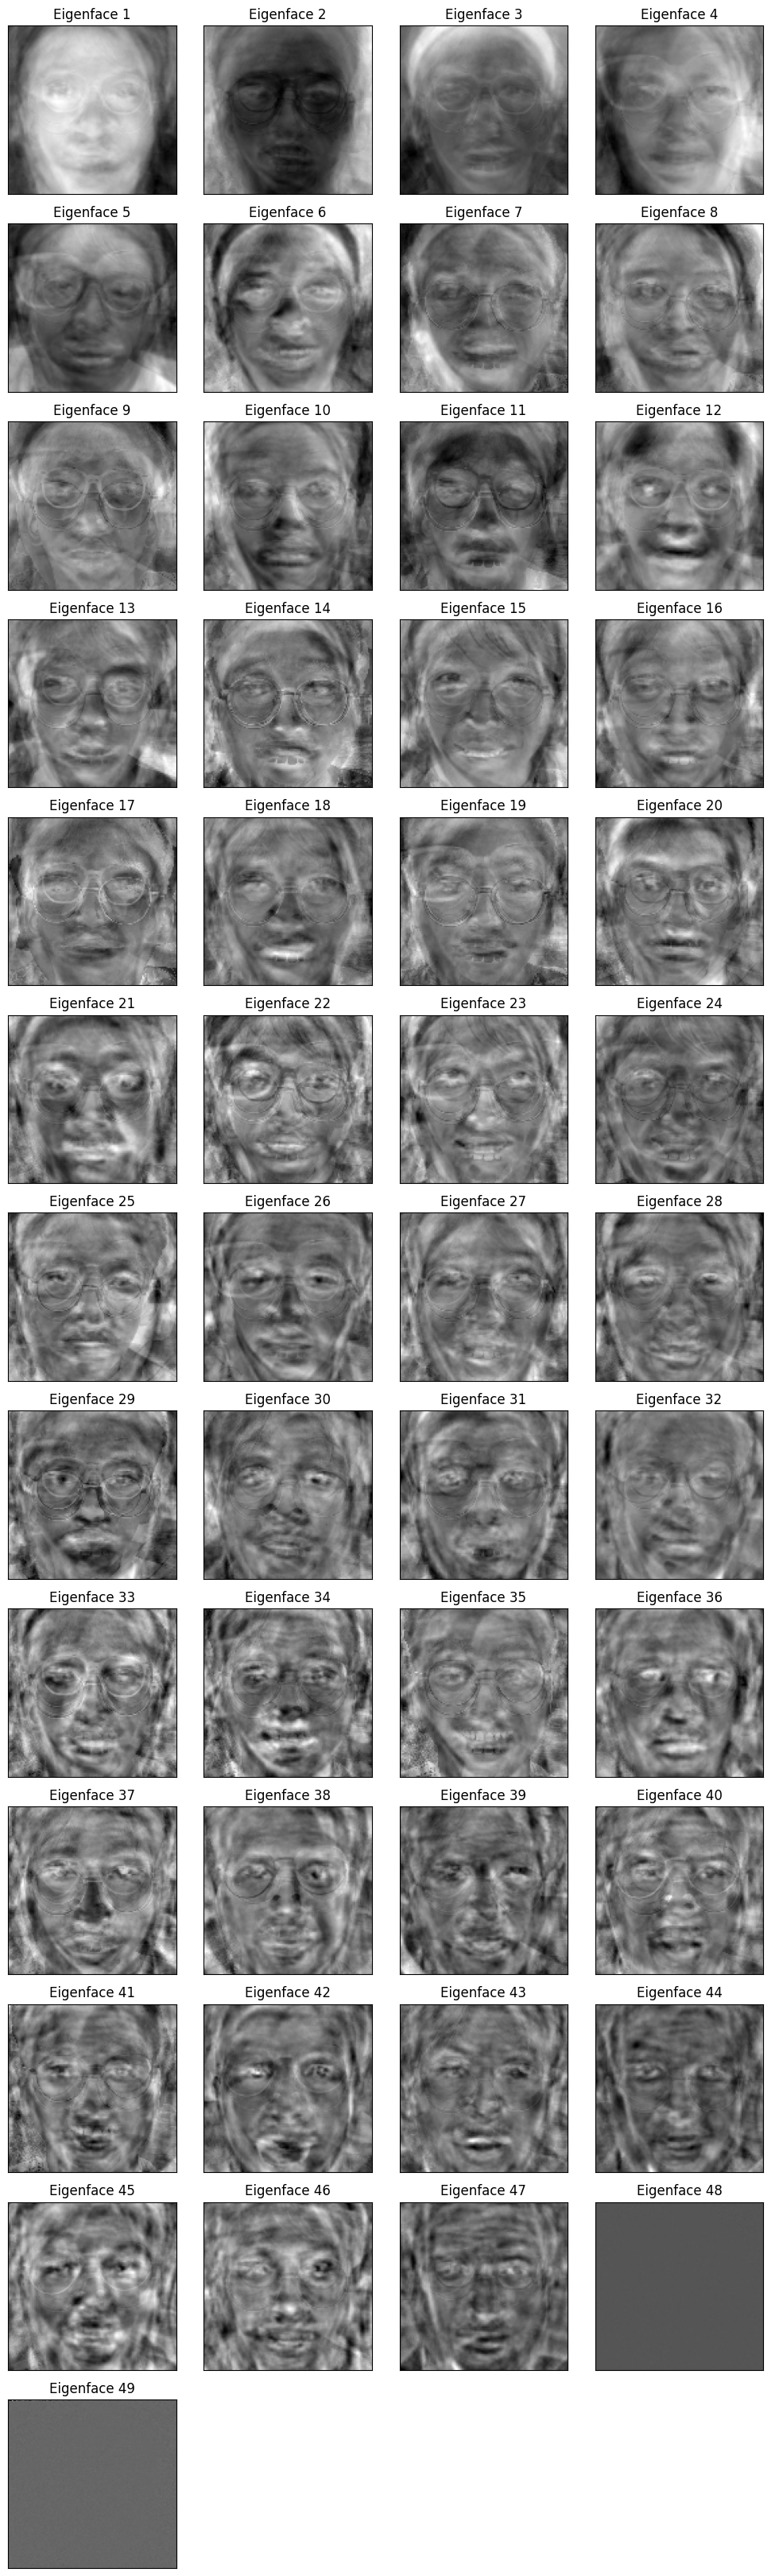

In [41]:
n_components = len(pipe[1].components_)

ncol = 4
nrow = (n_components + ncol - 1) // ncol
fig, axes = plt.subplots(
    nrow,
    ncol,
    figsize=(10, 2.5*nrow),
    subplot_kw={'xticks':[], 'yticks':[]}
)

eigenfaces = pipe[1].components_.reshape((n_components, X_train.shape[1]))
for i, ax in enumerate(axes.flat):
    if i < n_components:
        ax.imshow(eigenfaces[i].reshape(face_size), cmap='gray')
        ax.set_title(f'Eigenface {i+1}')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

### Save Model Pipeline

In [54]:
import pickle

with open('face_recognition_eigenface.pkl', 'wb') as f:
  pickle.dump(pipe, f)

### Combine All Methods

In [43]:
def get_eigenface_score(X):
  X_pca = pipe[:2].transform(X)
  eigenface_scores = np.max(pipe[2].decision_function(X_pca), axis=1)
  return eigenface_scores

In [44]:
def eigenface_prediction(image_gray):
  faces = detect_faces(image_gray)
  cropped_faces, selected_faces = crop_faces(image_gray, faces)

  if len(cropped_faces) == 0:
    return 'No face detected.'

  X_face = []
  for face in cropped_faces:
    face_flattened = resize_and_flatten(face)
    X_face.append(face_flattened)

  X_face = np.array(X_face)
  labels = pipe.predict(X_face)
  scores = get_eigenface_score(X_face)
  return scores, labels, selected_faces

In [45]:
sample_scores, sample_labels, sample_faces = eigenface_prediction(sample_image_gray)

In [46]:
sample_scores

array([6.28571429])

In [47]:
sample_labels

array(['Muh_Hafiz_Ardiansyah'], dtype='<U20')

In [48]:
sample_faces

[(np.int32(238), np.int32(218), np.int32(699), np.int32(699))]

In [49]:
def draw_text(image, label, score,
              font=cv2.FONT_HERSHEY_SIMPLEX,
              pos=(0, 0),
              font_scale=1.25,
              font_thickness=2,
              text_color=(0, 0, 0),
              text_color_bg=(0, 255, 0)
              ):

  x, y = pos
  score_text = f'Score: {score:.2f}'
  (w1, h1), _ = cv2.getTextSize(score_text, font, font_scale, font_thickness)
  (w2, h2), _ = cv2.getTextSize(label, font, font_scale, font_thickness)
  cv2.rectangle(image, (x, y-h1-h2-25), (x + max(w1, w2)+20, y), text_color_bg, -1)
  cv2.putText(image, label, (x+10, y-10), font, font_scale, text_color, font_thickness)
  cv2.putText(image, score_text, (x+10, y-h2-15), font, font_scale, text_color, font_thickness)

In [50]:
def draw_result(image, scores, labels, coords):
  result_image = image.copy()
  for (x, y, w, h), label, score in zip(coords, labels, scores):
    cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    draw_text(result_image, label, score, pos=(x, y))
  return result_image

In [51]:
result_image = draw_result(sample_image, sample_scores, sample_labels, sample_faces)

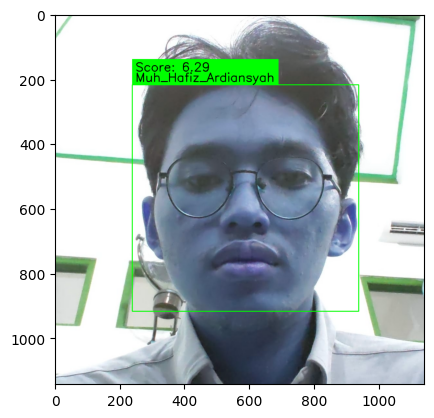

In [52]:
plt.imshow(result_image)

# Uji Coba Secara Real-Time Menggunakan Webcam

In [ ]:
import cv2

def test_webcam():
    # Inisialisasi webcam
    cap = cv2.VideoCapture(0)
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        # Konversi ke grayscale
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Deteksi wajah dan prediksi menggunakan Eigenface
        result = eigenface_prediction(frame_gray)
        if isinstance(result, str):
            print(result)
            continue
            
        scores, labels, faces = result
        
        # Gambar hasil deteksi dan prediksi
        result_frame = draw_result(frame, scores, labels, faces)
        
        # Menampilkan hasil
        cv2.imshow('Face Recognition', result_frame)
        
        # Keluar jika tombol 'q' ditekan
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

test_webcam()

No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face detected.
No face de